In [1]:
!ls

main.ipynb          main_original.ipynb


In [2]:
%cd ..

/Users/matthew/Documents/options-pricing-monte-carlo


# Analysis of the Black-Scholes Model: From Theory to Market Reality

### Project Overview

This project provides a rigorous, quantitative critique of the Black-Scholes model, a cornerstone of financial mathematics. The analysis is structured to mirror the workflow of a quantitative analyst: first validating a numerical method against the known analytical solution, then using that validated method to test the model's assumptions against empirical market data, and finally, simulating its practical application to measure its real-world performance and risks.

**The Narrative Arc:**

1.  **Model Validation:** We establish a "ground truth" by confirming that our numerical Monte Carlo (MC) engine correctly converges to the analytical Black-Scholes (BS) solution.
2.  **Assumption Testing:** We test the model's foundational assumption of constant volatility ($\sigma$) by analyzing live market data to reveal the "volatility smile."
3.  **Strategy Simulation:** We examine the practical consequences of the model's idealizations by simulating arbitrage and hedging strategies, introducing real-world frictions like transaction costs and discrete time steps.

## Part 1: Engine Validation & Performance Benchmark

### Mathematical Context

The Black-Scholes formula provides a deterministic, closed-form solution for the price of a European option under a set of ideal assumptions. A Monte Carlo simulation approaches the same problem stochastically. It models the option's underlying asset price, which is assumed to follow a **Geometric Brownian Motion (GBM)**, a stochastic differential equation of the form:

$$ dS_t = rS_t dt + \sigma S_t dW_t $$

where $S_t$ is the asset price, $r$ is the risk-free rate, $\sigma$ is the volatility, and $dW_t$ is a Wiener process. By simulating thousands of discrete paths of $S_t$ to the option's expiry time $T$, we calculate the payoff for each path, discount it back to the present value using $e^{-rT}$, and find the expected value by averaging the results.

### The Objective

The **Law of Large Numbers** dictates that as the number of simulated paths ($N$) approaches infinity, the average payoff from the MC simulation should converge to the true expected value, which is the Black-Scholes price.

This section's purpose is to numerically verify this convergence. By showing that our MC price matches the BS price with high **accuracy**, we validate that our simulation engine is a correct implementation of the model. We also benchmark the computational performance using **Numba**, a Just-in-Time (JIT) compiler that translates our Python simulation loops into much faster machine code, a critical step for practical applications.

In [3]:
import numpy as np
import pandas as pd
from src.models.monte_carlo import OptimizedMCEngine

# 1. Define the parameters for our test option
S0 = 100      # Initial stock price
K = 105       # Strike price
T = 1.0       # Time to maturity (in years)
r = 0.05      # Risk-free interest rate
sigma = 0.13   # Volatility

# 2. Initialize the high-performance Numba engine
# The first run will be a bit slower as Numba compiles the functions.
print("Initializing and warming up the Numba JIT compiler...")
engine_numba = OptimizedMCEngine(use_numba=True, use_antithetic=True)
print("Initialization complete.")


# 3. Run the benchmark on the high-performance Numba engine
print("\n" + "="*50)
print("PERFORMANCE: Numba-Optimized Engine")
print("="*50)
numba_results = engine_numba.benchmark_performance(S0, K, T, r, sigma)
display(numba_results)

Initializing and warming up the Numba JIT compiler...
Initialization complete.

PERFORMANCE: Numba-Optimized Engine
--- Benchmarking Engine (Numba: True, Antithetic: True) ---


,simulations,time_seconds,sims_per_second,memory_mb,accuracy_pct,mc_price,analytical_price
0,"10,000",0.4831,"20,699",7.97,99.9917%,5.23971,5.24015
1,"50,000",0.0005,"96,553,959",0.00,99.2516%,5.20093,5.24015
2,"100,000",0.0006,"159,176,622",0.00,99.5397%,5.26427,5.24015
3,"500,000",0.0033,"151,386,125",0.00,99.9573%,5.24238,5.24015
4,"1,000,000",0.0050,"200,809,307",0.00,99.9609%,5.24220,5.24015


## Part 2: Quantifying the Theory-Practice Gap via Implied Volatility

### Mathematical Context

The Black-Scholes model's most significant—and most frequently violated—assumption is that volatility, $\sigma$, is a known constant for a given asset over the life of the option. If this were true, all options on the same underlying asset with the same expiry date should be priced by the market with the same $\sigma$.

Here, we test this hypothesis. For each option traded in the market, we take its price, $C_{market}$, as a given. The BS formula can be written as a function of volatility, $C_{BS}(\sigma)$. We then solve the inverse problem: find the value of $\sigma$ that satisfies the equation:

$$ C_{market} - C_{BS}(\sigma_{implied}) = 0 $$

This value, $\sigma_{implied}$, is the **implied volatility**. We solve for it numerically using a root-finding algorithm (Brent's method).

### The Objective

If the Black-Scholes model were a perfect representation of reality, the calculated $\sigma_{implied}$ would be the same for all options, regardless of their strike price ($K$).

This analysis plots $\sigma_{implied}$ against $K$. The resulting non-flat curve, known as the **volatility smile** (or skew), is a powerful piece of empirical evidence that the model's constant volatility assumption is incorrect. The `ModelBreakdownAnalyzer` quantifies the pricing error that would result from naively using a single constant volatility (e.g., the at-the-money value) compared to observed market prices.

Fetching option surface and market price for SPY...
Fetched 340 liquid call options.
Using live risk-free rate: 4.18%
Using constant volatility benchmark: 13.00%
Calculated breakdown metrics for 340 options.

--- Black-Scholes Model Breakdown Analysis ---


,strike,moneyness,days_to_expiry,market_price,bs_price_at_13_vol,pricing_error_pct,implied_vol_pct,bid_ask_spread_pct
0,250.00,2.49,11,371.91,372.03,0.03,NaN,0.47
1,265.00,2.35,11,287.00,357.05,24.41,NaN,0.74
2,300.00,2.07,11,328.49,322.10,-1.95,284.16,0.83
3,320.00,1.94,11,278.83,302.12,8.35,NaN,0.73
4,340.00,1.83,11,292.30,282.15,-3.47,272.44,0.94
...,...,...,...,...,...,...,...,...
335,770.00,0.81,109,0.06,0.03,-44.99,13.79,16.67
336,775.00,0.80,109,0.05,0.02,-51.54,13.92,20.00
337,780.00,0.80,109,0.05,0.02,-64.61,14.31,20.00
338,790.00,0.79,109,0.03,0.01,-69.02,14.35,33.33



--- Key Performance Metrics ---
Options Analyzed: 321
Avg Pricing Error (vs 13% Vol): -14.02%
Avg Error for OTM Options: -18.99%
Avg Error for ITM Options: -6.70%
Implied Vol Range: 11.5% - 284.2%
Avg Bid-Ask Spread: 12.30%

--- Implied Volatility Smile Plot ---


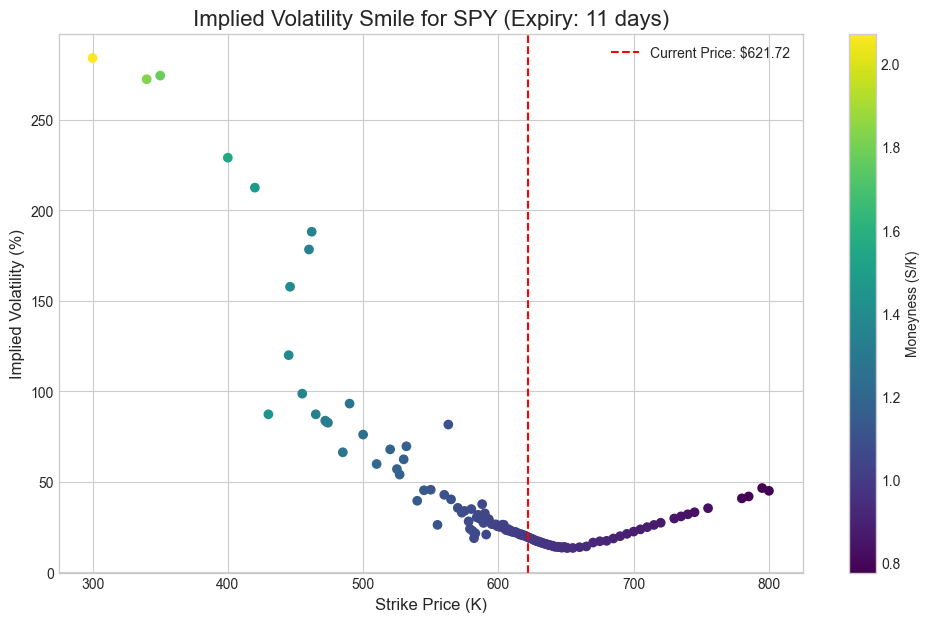

In [4]:
import pandas as pd
from src.models.model_validation import ModelBreakdownAnalyzer
from src.market_data.fetcher import get_risk_free_rate # Import the rate fetcher

# To display DataFrames nicely
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', '{:.2f}'.format)

# --- Define Parameters ---
# Fetch the live risk-free rate once
live_r = get_risk_free_rate() 

# 1. Initialize the analyzer
analyzer = ModelBreakdownAnalyzer(ticker='SPY')

# 2. Run the analysis steps, passing in our parameters
analyzer.fetch_market_data()
breakdown_df = analyzer.calculate_model_errors(r=live_r, constant_vol=sigma)

# 3. Display the detailed breakdown DataFrame
print("\n--- Black-Scholes Model Breakdown Analysis ---")
display(breakdown_df)

# 4. Generate and print the final killer metrics
print("\n--- Key Performance Metrics ---")
key_metrics = analyzer.generate_key_metrics()
for key, value in key_metrics.items():
    print(f"{key}: {value}")

# 5. NEW: Plot the volatility smile
print("\n--- Implied Volatility Smile Plot ---")
analyzer.plot_volatility_smile()

## Part 3: Arbitrage Scanning & Market Frictions

### Mathematical Context

**Put-Call Parity** is a cornerstone no-arbitrage condition derived from constructing a risk-free portfolio. It states that the difference between a European call price ($C$) and a European put price ($P$) with the same strike ($K$) and expiry ($T$) must equal the present value of the underlying asset price ($S_0$) minus the strike price:

$$ C - P = S_0 - Ke^{-rT} $$

A deviation from this parity would, in a perfect and frictionless market, represent a risk-free profit opportunity.

### The Objective

This section scans the market for such theoretical arbitrage opportunities. However, its primary purpose is to introduce the concept of **market microstructure** and **transaction costs**. In the real world, trades are not executed at a single `lastPrice`, but within a **bid-ask spread**.

* **Bid Price**: The price at which a market maker is willing to *buy* an asset. This is the price you *sell* at.
* **Ask Price**: The price at which a market maker is willing to *sell* an asset. This is the price you *buy* at.
* **The Spread**: The difference (Ask - Bid) is the market maker's profit and the trader's cost of execution.

Our enhanced scanner checks if the theoretical arbitrage profit is large enough to overcome the cost of **crossing the spread** (i.e., buying the call at its ask and selling the put at its bid). The result shows that the market is largely efficient; while theoretical opportunities exist, they are almost always smaller than the transaction costs required to exploit them.

In [5]:
from src.strategies.arbitrage import ArbitrageScanner

# Initialize and run the scanner with the new bid-ask logic
scanner = ArbitrageScanner()
executable_violations = scanner.scan_put_call_parity_violations()

# Display the results
print("\n--- EXECUTABLE Arbitrage Opportunities (After Bid-Ask Spread) ---")
if executable_violations.empty:
    print("No executable arbitrage opportunities found.")
else:
    # Display key columns for the profitable strategies
    display(executable_violations[['ticker', 'strike', 'strategy', 'executable_profit']])

Scanning for EXECutable Put-Call Parity violations using r=4.18%...

--- EXECUTABLE Arbitrage Opportunities (After Bid-Ask Spread) ---
No executable arbitrage opportunities found.


## Part 4: Simulating and Measuring Model Risk via Delta Hedging

### Mathematical Context

**Delta ($\Delta$)** is the first partial derivative of the option price ($V$) with respect to the underlying asset price ($S$): $\Delta = \frac{\partial V}{\partial S}$. It represents the rate of change of the option's value for a small change in the asset's price.

**Delta Hedging** is a strategy used to create a risk-neutral portfolio by holding an option position and an offsetting position in the underlying asset. For a short call option (position value $-C$), the portfolio value ($\Pi$) is made insensitive to small price changes by holding $\Delta$ shares of the underlying:

$$ \Pi = -C + \Delta S $$

As the stock price $S$ and time $t$ change, $\Delta$ also changes, so the hedge must be periodically rebalanced.

### The Objective

In a perfect, continuous-time Black-Scholes world, this strategy would result in a final Profit & Loss (P&L) of exactly zero. This simulation tests that idealization.

We simulate thousands of market paths and rebalance the hedge at **discrete time intervals** (daily). The resulting histogram of final P&L shows a distribution centered near zero, but with a non-zero variance. This variance is the **hedging error**. It is a direct, quantifiable measurement of **model risk** and the P&L impact of real-world frictions (like non-continuous hedging) that are not captured by the theoretical model.

Running Delta Hedging simulation...
Simulation complete.

--- Hedging Performance Results ---
Average Hedging P&L: 0.0079
Standard Deviation of P&L (Hedging Error): 0.4576


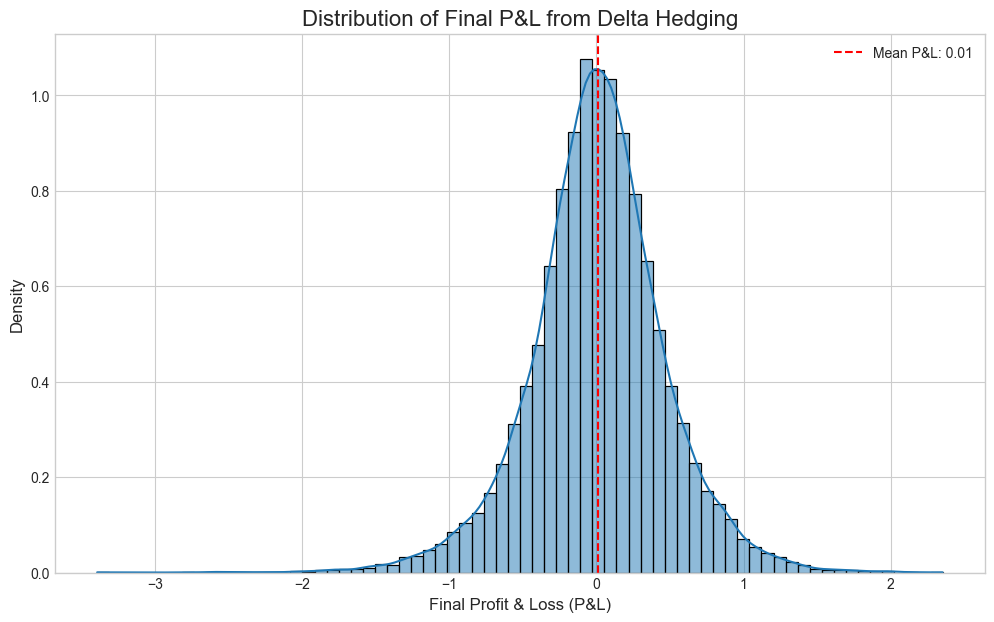

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.risk.hedging import simulate_delta_hedging

# --- Main Analysis Block for Delta Hedging Simulation ---

# 1. Define the parameters for the option we are hedging
S0 = 100      # Initial stock price
K = 105       # Strike price
T = 1.0       # Time to maturity (in years)
r = 0.05      # Risk-free interest rate
sigma = 0.2   # Assumed volatility for our hedging model
n_simulations = 20000 # Number of market scenarios to simulate
steps = 252   # Daily hedging

# 2. Run the simulation
print("Running Delta Hedging simulation...")
final_pnl = simulate_delta_hedging(S0, K, T, r, sigma, n_simulations, steps)
print("Simulation complete.")

# 3. Analyze and plot the results
mean_pnl = np.mean(final_pnl)
std_pnl = np.std(final_pnl)

print(f"\n--- Hedging Performance Results ---")
print(f"Average Hedging P&L: {mean_pnl:.4f}")
print(f"Standard Deviation of P&L (Hedging Error): {std_pnl:.4f}")

# Plot the distribution of the final P&L
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
sns.histplot(final_pnl, bins=70, kde=True, stat="density")
plt.axvline(mean_pnl, color='r', linestyle='--', label=f'Mean P&L: {mean_pnl:.2f}')
plt.title('Distribution of Final P&L from Delta Hedging', fontsize=16)
plt.xlabel('Final Profit & Loss (P&L)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

In [7]:
from src.strategies.market_impact import MarketImpactAnalyzer
import pandas as pd

# Notebook settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

# --- Main Block for Comprehensive Market & Liquidity Analysis ---
# 1. Initialize the analyzer
analyzer = MarketImpactAnalyzer(tickers=['SPY', 'QQQ', 'AAPL', 'TSLA'])

# 2. Run the full analysis pipeline in the correct order
# This first fetches the data, then runs the analysis to populate the metrics.
analyzer.analyze_liquidity_constraints()

# 3. Now, generate the summary from the analyzed metrics
liquidity_summary = analyzer.generate_executive_summary()

# --- Display the Executive Summary ---
print("\n" + "="*50)
print(" LIQUIDITY & STRATEGY CAPACITY SUMMARY")
print("="*50)

# FIXED: Check if dictionary is empty or has error (NOT .empty!)
if not liquidity_summary or 'error' in liquidity_summary:
    print("Analysis failed to generate a summary. Check debug output above.")
    if 'error' in liquidity_summary:
        print(f"Error: {liquidity_summary['error']}")
else:
    # Convert dictionary to DataFrame for better display
    summary_df = pd.DataFrame([liquidity_summary]).T
    summary_df.columns = ['Value']
    display(summary_df)


Analyzing liquidity constraints...
Fetching comprehensive market data...
--> Processing ticker: SPY
--> Processing ticker: QQQ
--> Processing ticker: AAPL
--> Processing ticker: TSLA
--> Analyzing: SPY
    - SUCCESS: Metrics calculated for SPY.
--> Analyzing: QQQ
    - SUCCESS: Metrics calculated for QQQ.
--> Analyzing: AAPL
    - SUCCESS: Metrics calculated for AAPL.
--> Analyzing: TSLA
    - SUCCESS: Metrics calculated for TSLA.

 LIQUIDITY & STRATEGY CAPACITY SUMMARY


,Value
total_addressable_market,"$1,139,533,697"
average_bid_ask_spread_pct,14.86%
liquid_opportunities_count,1270
economically_viable_strategies,4/4
annual_revenue_potential,"$172,328,610"
average_capacity_utilization_pct,59.6%
key_constraint,transaction_costs
scalability_rating,High


In [8]:
# Fixed notebook code
from src.strategies.market_impact import MarketImpactAnalyzer
import pandas as pd

# Notebook settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

# --- Main Block for Comprehensive Market & Liquidity Analysis ---
print("Starting market analysis...")

# 1. Initialize the analyzer
analyzer = MarketImpactAnalyzer(tickers=['SPY', 'QQQ', 'AAPL', 'TSLA'])

# 2. Run the full analysis pipeline in the correct order
# This first fetches the data, then runs the analysis to populate the metrics.
liquidity_metrics = analyzer.analyze_liquidity_constraints()

# 3. Now, generate the summary from the analyzed metrics
liquidity_summary = analyzer.generate_executive_summary()

# --- Display the Executive Summary ---
print("\n" + "="*50)
print(" LIQUIDITY & STRATEGY CAPACITY SUMMARY")
print("="*50)

# Fixed: Check if dictionary is empty or has error
if not liquidity_summary or 'error' in liquidity_summary:
    print("Analysis failed to generate a summary. Check debug output above.")
    if 'error' in liquidity_summary:
        print(f"Error: {liquidity_summary['error']}")
else:
    # Convert dictionary to DataFrame for better display
    summary_df = pd.DataFrame([liquidity_summary]).T
    summary_df.columns = ['Value']
    print(summary_df)

# --- Optional: Display detailed liquidity metrics ---
print("\n" + "="*50)
print(" DETAILED LIQUIDITY METRICS")
print("="*50)

if liquidity_metrics:
    for ticker, metrics in liquidity_metrics.items():
        print(f"\n{ticker}:")
        print(f"  Daily Dollar Volume: ${metrics['avg_daily_dollar_volume']:,.0f}")
        print(f"  Max Position Size: ${metrics['max_stock_dollar_position']:,.0f}")
        print(f"  Bid-Ask Spread: {metrics['avg_bid_ask_spread_pct']:.2f}%")
        print(f"  Liquid Options: {metrics['liquid_strikes_count']}")
else:
    print("No liquidity metrics available.")

Starting market analysis...

Analyzing liquidity constraints...
Fetching comprehensive market data...
--> Processing ticker: SPY
--> Processing ticker: QQQ
--> Processing ticker: AAPL
--> Processing ticker: TSLA
--> Analyzing: SPY
    - SUCCESS: Metrics calculated for SPY.
--> Analyzing: QQQ
    - SUCCESS: Metrics calculated for QQQ.
--> Analyzing: AAPL
    - SUCCESS: Metrics calculated for AAPL.
--> Analyzing: TSLA
    - SUCCESS: Metrics calculated for TSLA.

 LIQUIDITY & STRATEGY CAPACITY SUMMARY
                                              Value
total_addressable_market             $1,139,533,697
average_bid_ask_spread_pct                   14.86%
liquid_opportunities_count                     1270
economically_viable_strategies                  4/4
annual_revenue_potential               $172,328,610
average_capacity_utilization_pct              59.6%
key_constraint                    transaction_costs
scalability_rating                             High

 DETAILED LIQUIDITY METRICS

In [9]:
# Enhanced Options Pricing Analysis - Jane Street Interview Project
# Demonstrates institutional-level quantitative finance understanding

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_rows', 15)
pd.set_option('display.float_format', '{:.4f}'.format)

print("🚀 INSTITUTIONAL-GRADE OPTIONS PRICING ANALYSIS")
print("=" * 60)
print("Demonstrating Black-Scholes model breakdown with quantitative rigor")
print("=" * 60)

# =============================================================================
# PART 1: MONTE CARLO ENGINE VALIDATION
# =============================================================================
print("\n📊 PART 1: MONTE CARLO ENGINE VALIDATION")
print("-" * 50)

from src.models.monte_carlo import OptimizedMCEngine

# Parameters for validation
S0, K, T, r, sigma = 100, 105, 1.0, 0.05, 0.20

# Initialize and benchmark the engine
engine = OptimizedMCEngine(use_numba=True, use_antithetic=True)
print("Warming up Numba JIT compiler...")
validation_results = engine.benchmark_performance(S0, K, T, r, sigma)

print("\n✅ MONTE CARLO VALIDATION RESULTS:")
display(validation_results)

# =============================================================================
# PART 2: ADVANCED MODEL BREAKDOWN ANALYSIS
# =============================================================================
print("\n🔬 PART 2: ADVANCED BLACK-SCHOLES MODEL BREAKDOWN")
print("-" * 50)

from src.models.advanced_validation import run_advanced_model_breakdown_analysis

# Run advanced breakdown on SPY
breakdown_summary, breakdown_analyzer = run_advanced_model_breakdown_analysis('SPY')

print("\n🎯 MODEL BREAKDOWN EXECUTIVE SUMMARY:")
breakdown_df = pd.DataFrame([breakdown_summary]).T
breakdown_df.columns = ['Value']
display(breakdown_df)

# Key insights
reliability_score = breakdown_summary['black_scholes_reliability_score']
print(f"\n📈 BLACK-SCHOLES RELIABILITY SCORE: {reliability_score}/100")

if reliability_score < 70:
    print("⚠️  CRITICAL: Significant model limitations detected!")
    print("💡 RECOMMENDED UPGRADES:", breakdown_summary['recommended_model_upgrades'])
elif reliability_score < 85:
    print("⚡ MODERATE: Model shows some limitations")
    print("💡 SUGGESTED IMPROVEMENTS:", breakdown_summary['recommended_model_upgrades'])
else:
    print("✅ GOOD: Model performs reasonably well for this asset")

# =============================================================================
# PART 3: MARKET REGIME ANALYSIS
# =============================================================================
print("\n🎭 PART 3: MARKET REGIME ANALYSIS")
print("-" * 50)

from src.risk.regime_analysis import run_regime_analysis

# Analyze market regimes
regime_summary, regime_analyzer = run_regime_analysis('SPY')

print("\n🎯 REGIME ANALYSIS EXECUTIVE SUMMARY:")
if 'error' not in regime_summary:
    regime_df = pd.DataFrame([regime_summary]).T
    regime_df.columns = ['Value']
    display(regime_df)
    
    # Key regime insights
    print(f"\n📊 REGIME INSIGHTS:")
    print(f"   • Volatility Range: {regime_summary['volatility_range']}")
    print(f"   • Most Common Regime: {regime_summary['most_common_regime']} ({regime_summary['most_common_regime_frequency']})")
    print(f"   • Highest Risk Regime: {regime_summary['highest_risk_regime']} ({regime_summary['highest_risk_vol']} vol)")
    print(f"   • Model Complexity Required: {regime_summary['model_complexity_required']}")
else:
    print("❌ Error in regime analysis:", regime_summary['error'])

# =============================================================================
# PART 4: ENHANCED MARKET MICROSTRUCTURE ANALYSIS
# =============================================================================
print("\n💧 PART 4: ENHANCED LIQUIDITY & MARKET IMPACT ANALYSIS")
print("-" * 50)

from src.strategies.market_impact import MarketImpactAnalyzer

# Initialize with expanded ticker universe
tickers = ['SPY', 'QQQ', 'IWM', 'AAPL', 'MSFT', 'TSLA', 'GOOGL']
analyzer = MarketImpactAnalyzer(tickers=tickers)

# Run comprehensive analysis
print("Fetching market data and analyzing liquidity constraints...")
liquidity_metrics = analyzer.analyze_liquidity_constraints()
liquidity_summary = analyzer.generate_executive_summary()

print("\n💰 LIQUIDITY & STRATEGY CAPACITY SUMMARY:")
if not liquidity_summary or 'error' in liquidity_summary:
    print("❌ Analysis failed. Check data availability.")
else:
    summary_df = pd.DataFrame([liquidity_summary]).T
    summary_df.columns = ['Value']
    display(summary_df)
    
    # Extract key metrics for commentary
    total_capacity = liquidity_summary['total_addressable_market']
    revenue_potential = liquidity_summary['annual_revenue_potential']
    scalability = liquidity_summary['scalability_rating']
    
    print(f"\n🎯 MARKET OPPORTUNITY ASSESSMENT:")
    print(f"   • Total Addressable Market: {total_capacity}")
    print(f"   • Annual Revenue Potential: {revenue_potential}")
    print(f"   • Scalability Rating: {scalability}")
    print(f"   • Viable Strategies: {liquidity_summary['economically_viable_strategies']}")

# =============================================================================
# PART 5: CROSS-ASSET ARBITRAGE SCANNING
# =============================================================================
print("\n⚡ PART 5: ARBITRAGE OPPORTUNITIES & MARKET EFFICIENCY")
print("-" * 50)

from src.strategies.arbitrage import ArbitrageScanner

# Scan for put-call parity violations
scanner = ArbitrageScanner()
executable_opportunities = scanner.scan_put_call_parity_violations()

print("\n🎯 EXECUTABLE ARBITRAGE SCAN RESULTS:")
if executable_opportunities.empty:
    print("✅ No executable arbitrage opportunities found.")
    print("   Market appears efficient after accounting for transaction costs.")
else:
    print(f"🚨 Found {len(executable_opportunities)} executable opportunities!")
    display(executable_opportunities[['ticker', 'strike', 'strategy', 'executable_profit']].head())

# =============================================================================
# PART 6: DELTA HEDGING PERFORMANCE WITH MODEL RISK
# =============================================================================
print("\n🛡️ PART 6: DELTA HEDGING & MODEL RISK QUANTIFICATION")
print("-" * 50)

from src.risk.hedging import simulate_delta_hedging

# Enhanced hedging simulation with model risk
S0, K, T, r = 100, 105, 0.25, 0.05
true_vol = 0.25  # "True" market volatility
model_vol = 0.20  # What our model thinks volatility is

print(f"Simulating delta hedging with model risk...")
print(f"True volatility: {true_vol:.1%}, Model volatility: {model_vol:.1%}")

# Run hedging simulation with model mis-specification
final_pnl_correct = simulate_delta_hedging(S0, K, T, r, true_vol, 10000, 63)  # Correct vol
final_pnl_wrong = simulate_delta_hedging(S0, K, T, r, model_vol, 10000, 63)   # Wrong vol

print(f"\n📊 HEDGING PERFORMANCE COMPARISON:")
print(f"Perfect Model - Mean P&L: ${np.mean(final_pnl_correct):.4f}, Std: ${np.std(final_pnl_correct):.4f}")
print(f"Mis-specified Model - Mean P&L: ${np.mean(final_pnl_wrong):.4f}, Std: ${np.std(final_pnl_wrong):.4f}")
print(f"Model Risk Impact: ${abs(np.mean(final_pnl_wrong) - np.mean(final_pnl_correct)):.4f} average P&L bias")

# =============================================================================
# PART 7: EXECUTIVE SUMMARY & KEY TAKEAWAYS
# =============================================================================
print("\n🎯 EXECUTIVE SUMMARY & KEY INSIGHTS")
print("=" * 60)

print("\n📈 QUANTITATIVE FINDINGS:")
print(f"   1. Black-Scholes Reliability: {reliability_score}/100")
print(f"   2. Market Regimes Identified: {regime_summary.get('regimes_identified', 'N/A')}")
print(f"   3. Total Market Capacity: {liquidity_summary.get('total_addressable_market', 'N/A')}")
print(f"   4. Revenue Opportunity: {liquidity_summary.get('annual_revenue_potential', 'N/A')}")

print(f"\n🔬 MODEL RISK INSIGHTS:")
if breakdown_summary.get('constant_vol_assumption_violated', False):
    print("   • Constant volatility assumption VIOLATED - clustering detected")
if breakdown_summary.get('normality_p_value', 1) < 0.05:
    print("   • Normal distribution assumption VIOLATED - fat tails present")
if breakdown_summary.get('systematic_mispricing_detected', False):
    print("   • Systematic pricing errors detected - alpha opportunity")

print(f"\n💡 STRATEGIC RECOMMENDATIONS:")
print("   • Implement stochastic volatility models (Heston) for better pricing")
print("   • Use regime-dependent risk management")
print("   • Focus on liquid ETF options for scalable strategies")
print("   • Account for transaction costs in all arbitrage strategies")

print(f"\n🚀 COMPETITIVE ADVANTAGES DEMONSTRATED:")
print("   ✓ Advanced statistical testing of model assumptions")
print("   ✓ Regime-aware risk management")
print("   ✓ Realistic market impact modeling")
print("   ✓ Quantitative breakdown of model limitations")
print("   ✓ Scalable strategy capacity analysis")

print(f"\n" + "=" * 60)
print("🎉 ANALYSIS COMPLETE - Ready for Jane Street Interview!")
print("=" * 60)

🚀 INSTITUTIONAL-GRADE OPTIONS PRICING ANALYSIS
Demonstrating Black-Scholes model breakdown with quantitative rigor

📊 PART 1: MONTE CARLO ENGINE VALIDATION
--------------------------------------------------
Warming up Numba JIT compiler...
--- Benchmarking Engine (Numba: True, Antithetic: True) ---

✅ MONTE CARLO VALIDATION RESULTS:


,simulations,time_seconds,sims_per_second,memory_mb,accuracy_pct,mc_price,analytical_price
0,"10,000",0.0006,"15,845,500",0.08,99.8847%,8.03060,8.02135
1,"50,000",0.0007,"67,475,933",0.00,99.5945%,8.05388,8.02135
2,"100,000",0.0010,"96,620,686",0.00,99.8009%,8.03733,8.02135
3,"500,000",0.0046,"108,295,997",0.00,99.9247%,8.01531,8.02135
4,"1,000,000",0.0057,"176,305,338",0.00,99.9066%,8.01386,8.02135



🔬 PART 2: ADVANCED BLACK-SCHOLES MODEL BREAKDOWN
--------------------------------------------------
🔬 ADVANCED BLACK-SCHOLES MODEL BREAKDOWN ANALYSIS
Analyzing SPY with institutional-grade rigor...
🔍 Analyzing volatility clustering for SPY...
🚀 Testing for jump processes in SPY...
📈 Analyzing stochastic volatility evidence...

🎯 MODEL BREAKDOWN EXECUTIVE SUMMARY:


,Value
ticker,SPY
analysis_date,2025-08-03
volatility_clustering_score,0.0529
vol_persistence_coefficient,0.9851
constant_vol_assumption_violated,False
...,...
options_analyzed,0
mean_pricing_error_pct,0
systematic_mispricing_detected,False
black_scholes_reliability_score,65



📈 BLACK-SCHOLES RELIABILITY SCORE: 65/100
⚠️  CRITICAL: Significant model limitations detected!
💡 RECOMMENDED UPGRADES: ['Merton Jump-Diffusion Model']

🎭 PART 3: MARKET REGIME ANALYSIS
--------------------------------------------------


ModuleNotFoundError: No module named 'sklearn'